In [58]:
import sys
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import functions as func
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, LongType
from math import sqrt
import matplotlib.pyplot as plt
from pyspark.sql.functions import col,isnan, when, count,mean,sum

In [6]:
spark = SparkSession.builder.appName("MovieSimilarities").master("local[*]").getOrCreate()

22/12/18 00:08:44 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [7]:
movieNamesSchema = StructType([\
                              StructField("movieID", IntegerType(),True), \
                              StructField("movieTitle",StringType(),True) \
                              ])

In [8]:
moviesSchema = StructType([\
                           StructField("userID", IntegerType(),True), \
                           StructField("movieID",IntegerType(),True), \
                           StructField("rating", IntegerType(),True), \
                           StructField("timestamp",LongType(),True)])

In [73]:
# create a broadcast dataset of movieID and movieTitle
movieNames = spark.read \
    .option("sep","|") \
    .option("charset","ISO-8859-1") \
    .schema(movieNamesSchema) \
    .csv("/home/qnhhoa/Downloads/ml-100k/u.item")

movieNames.printSchema()
movieNames.show(10)

root
 |-- movieID: integer (nullable = true)
 |-- movieTitle: string (nullable = true)

+-------+--------------------+
|movieID|          movieTitle|
+-------+--------------------+
|      1|    Toy Story (1995)|
|      2|    GoldenEye (1995)|
|      3|   Four Rooms (1995)|
|      4|   Get Shorty (1995)|
|      5|      Copycat (1995)|
|      6|Shanghai Triad (Y...|
|      7|Twelve Monkeys (1...|
|      8|         Babe (1995)|
|      9|Dead Man Walking ...|
|     10|  Richard III (1995)|
+-------+--------------------+
only showing top 10 rows



In [2]:
# get movie name
def loadMovieNames():
    movieNames = {}
    with open("/home/qnhhoa/Downloads/ml-100k/u.item",encoding = "ISO-8859-1") as f:
        for line in f:
            fields = line.split('|')
            movieNames[int(fields[0])] = fields[1].encode().decode('ascii','ignore')
    return movieNames

loadMovieNames()

{1: 'Toy Story (1995)',
 2: 'GoldenEye (1995)',
 3: 'Four Rooms (1995)',
 4: 'Get Shorty (1995)',
 5: 'Copycat (1995)',
 6: 'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)',
 7: 'Twelve Monkeys (1995)',
 8: 'Babe (1995)',
 9: 'Dead Man Walking (1995)',
 10: 'Richard III (1995)',
 11: 'Seven (Se7en) (1995)',
 12: 'Usual Suspects, The (1995)',
 13: 'Mighty Aphrodite (1995)',
 14: 'Postino, Il (1994)',
 15: "Mr. Holland's Opus (1995)",
 16: 'French Twist (Gazon maudit) (1995)',
 17: 'From Dusk Till Dawn (1996)',
 18: 'White Balloon, The (1995)',
 19: "Antonia's Line (1995)",
 20: 'Angels and Insects (1995)',
 21: 'Muppet Treasure Island (1996)',
 22: 'Braveheart (1995)',
 23: 'Taxi Driver (1976)',
 24: 'Rumble in the Bronx (1995)',
 25: 'Birdcage, The (1996)',
 26: 'Brothers McMullen, The (1995)',
 27: 'Bad Boys (1995)',
 28: 'Apollo 13 (1995)',
 29: 'Batman Forever (1995)',
 30: 'Belle de jour (1967)',
 31: 'Crimson Tide (1995)',
 32: 'Crumb (1994)',
 33: 'Desperado (1995)',
 34: '

In [80]:
# # get movie name by given MovieID
# def getMovieName(movieNames,movieId):
#     result = movieNames.filter(func.col("movieID")== movieId) \
#         .select("movieTitle").collect()[0]
    
#     return result[0]


In [72]:
# load up movie data as dataset
movies = spark.read \
    .option("sep","\t") \
    .schema(moviesSchema) \
    .csv("/home/qnhhoa/Downloads/ml-100k/u.data")

movies.printSchema()
movies.show(10)

root
 |-- userID: integer (nullable = true)
 |-- movieID: integer (nullable = true)
 |-- rating: integer (nullable = true)
 |-- timestamp: long (nullable = true)

+------+-------+------+---------+
|userID|movieID|rating|timestamp|
+------+-------+------+---------+
|   196|    242|     3|881250949|
|   186|    302|     3|891717742|
|    22|    377|     1|878887116|
|   244|     51|     2|880606923|
|   166|    346|     1|886397596|
|   298|    474|     4|884182806|
|   115|    265|     2|881171488|
|   253|    465|     5|891628467|
|   305|    451|     3|886324817|
|     6|     86|     3|883603013|
+------+-------+------+---------+
only showing top 10 rows



In [13]:
# take 3 columns needed
ratings = movies.select("userId","movieId","rating")

In [76]:
ratings.describe().show()
ratings.show(10)

+-------+------------------+------------------+------------------+
|summary|            userId|           movieId|            rating|
+-------+------------------+------------------+------------------+
|  count|            100000|            100000|            100000|
|   mean|         462.48475|         425.53013|           3.52986|
| stddev|266.61442012750905|330.79835632558473|1.1256735991443214|
|    min|                 1|                 1|                 1|
|    max|               943|              1682|                 5|
+-------+------------------+------------------+------------------+

+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|   196|    242|     3|
|   186|    302|     3|
|    22|    377|     1|
|   244|     51|     2|
|   166|    346|     1|
|   298|    474|     4|
|   115|    265|     2|
|   253|    465|     5|
|   305|    451|     3|
|     6|     86|     3|
+------+-------+------+
only showing top 10 rows



In [90]:
# check null data
ratings.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in ratings.columns]
   ).show()

+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|     0|      0|     0|
+------+-------+------+



(array([ 6110.,     0.,     0.,     0.,     0., 11370.,     0.,     0.,
            0.,     0., 27145.,     0.,     0.,     0.,     0., 34174.,
            0.,     0.,     0., 21201.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. , 3.2, 3.4,
        3.6, 3.8, 4. , 4.2, 4.4, 4.6, 4.8, 5. ]),
 <BarContainer object of 20 artists>)

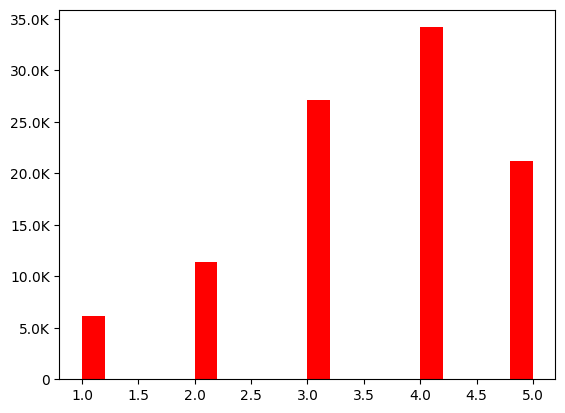

In [15]:
# visualize rating colum
from pyspark_dist_explore import hist
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
hist(ax, ratings.select('rating'), bins = 20, color=['red'])

In [16]:
# avg rating of movie
ratings.groupBy("movieId").mean("rating").show()

+-------+------------------+
|movieId|       avg(rating)|
+-------+------------------+
|    496| 4.121212121212121|
|    471|3.6108597285067874|
|    463| 3.859154929577465|
|    148|          3.203125|
|   1342|               2.5|
|    833| 3.204081632653061|
|   1088| 2.230769230769231|
|   1591|3.1666666666666665|
|   1238|             3.125|
|   1580|               1.0|
|   1645|               4.0|
|    392|3.5441176470588234|
|    623| 2.923076923076923|
|    540| 2.511627906976744|
|    858|               1.0|
|    737| 2.983050847457627|
|    243|2.4393939393939394|
|   1025|2.9318181818181817|
|   1084| 3.857142857142857|
|   1127| 2.909090909090909|
+-------+------------------+
only showing top 20 rows



In [79]:
# count movie ratings
ratings.groupBy("movieId","rating").count().show()

+-------+------+-----+
|movieId|rating|count|
+-------+------+-----+
|    979|     2|    6|
|    248|     4|   83|
|   1267|     3|   16|
|   1079|     3|    9|
|     71|     4|   75|
|    626|     4|    1|
|   1070|     5|    6|
|    203|     4|   88|
|   1350|     2|    1|
|    515|     5|   88|
|    678|     2|   58|
|    162|     3|   42|
|    639|     5|    8|
|   1384|     1|    2|
|   1000|     4|    2|
|   1010|     4|   13|
|    307|     2|   21|
|    688|     3|    7|
|    444|     3|   15|
|    984|     5|    6|
+-------+------+-----+
only showing top 20 rows



In [84]:
# emit every movie rated together by the same user
# self-join to find every combination
# select movie Pairs and rating pairs
moviePairs = ratings.alias("ratings1") \
    .join(ratings.alias("ratings2"),(func.col("ratings1.userId") == func.col("ratings2.userId"))
         &(func.col("ratings1.movieId") < func.col("ratings2.movieId"))) \
    .select(func.col("ratings1.movieId").alias("movie1"), \
           func.col("ratings2.movieId").alias("movie2"), \
           func.col("ratings1.rating").alias("rating1"), \
           func.col("ratings2.rating").alias("rating2"))

In [85]:
def computeCosineSimilarity(spark,data):
    pairScores = data \
        .withColumn("xx",func.col("rating1")*func.col("rating1")) \
        .withColumn("yy",func.col("rating2")*func.col("rating2")) \
        .withColumn("xy",func.col("rating1")*func.col("rating2")) 
#     tinh tu, mau, numPairs
    calculateSimilarity = pairScores \
        .groupBy("movie1","movie2") \
        .agg(\
            func.sum(func.col("xy")).alias("numerator"), \
            (func.sqrt(func.sum(func.col("xx")))* func.sqrt(func.sum(func.col("yy")))).alias("denominator"),\
            func.count(func.col("xy")).alias("numPairs")
        )
#     calculate score
    result = calculateSimilarity \
        .withColumn("score", \
           func.when(func.col("denominator")!= 0, func.col("numerator") / func.col("denominator"))\
           .otherwise(0)  
        ).select("movie1","movie2","score","numPairs")
    return result

In [86]:
moviePairSimilarities = computeCosineSimilarity(spark,moviePairs).cache()

In [92]:
if (len(sys.argv) > 1):
    
    scoreThreshold = 0.97
    coOccurenceThreshold = 50.0
    
#     movieID = int(sys.argv[1])
    movieID = 50
    
#     filter movie pair and use some quality thresholds above
    filteredResults = moviePairSimilarities.filter( \
        ((func.col("movie1") == movieID) | (func.col("movie2") == movieID)) & \
            (func.col("score") > scoreThreshold) & (func.col("numPairs") > coOccurenceThreshold))
    
#     take top 10 movies with the highest score
    results = filteredResults.sort(func.col("score").desc()).take(10)
#     load movie name
    nameDict = loadMovieNames()
    print ("Top 10 similar movies for" + nameDict[movieID])
    
    for result in results:
#   display the similarity result that isn't the movie we're looking at
        similarMovieID = result.movie1
        if(similarMovieID == movieID):
            similarMovieID = result.movie2
            
        print(nameDict[similarMovieID] + "\tscore: " \
              + str(result.score) + "\tstrength: " + str(result.numPairs))

Top 10 similar movies forStar Wars (1977)
Empire Strikes Back, The (1980)	score: 0.9895522078385338	strength: 345
Return of the Jedi (1983)	score: 0.9857230861253026	strength: 480
Raiders of the Lost Ark (1981)	score: 0.981760098872619	strength: 380
20,000 Leagues Under the Sea (1954)	score: 0.9789385605497993	strength: 68
12 Angry Men (1957)	score: 0.9776576120448436	strength: 109
Close Shave, A (1995)	score: 0.9775948291054827	strength: 92
African Queen, The (1951)	score: 0.9764692222674887	strength: 138
Sting, The (1973)	score: 0.9751512937740359	strength: 204
Wrong Trousers, The (1993)	score: 0.9748681355460885	strength: 103
Wallace & Gromit: The Best of Aardman Animation (1996)	score: 0.9741816128302572	strength: 58
